<h1><font color="#113D68" size=6>Tema 5 - Conjuntos borrosos</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>1. Fundamentos de Conjuntos Borrosos y Variables Lingüísticas</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Entender la pertenencia gradual y cómo modelar conocimiento impreciso con **conjuntos borrosos** y **variables lingüísticas**.

**Qué aprenderás**
- Definir funciones de pertenencia típicas: **triangular**, **trapezoidal**, **gaussiana**.
- Operar con conjuntos borrosos: **complemento**, **intersección** (T-normas) y **unión** (S-normas).
- Construir una **variable lingüística** (universo + etiquetas “bajo/medio/alto”) y **fuzzificar** valores.
- Explorar de forma **interactiva** el efecto de los parámetros en la forma de $\mu(x)$.

**Conexión con teoría (cap. 7 del libro)**
- Secciones 7.1–7.4: semántica de pertenencia, formas habituales y operaciones.
- Preparación para 5.2: principio de extensión, inferencia Mamdani y cuantificación lingüística.

In [1]:
# 1) Arranque: imports y estilo
import numpy as np
import matplotlib.pyplot as plt

try:
    from ipywidgets import interact, fixed, FloatSlider, Dropdown
    _HAS_WIDGETS = True
except Exception:
    _HAS_WIDGETS = False

plt.rcParams['figure.figsize'] = (6.4, 3.8)
plt.rcParams['axes.grid'] = True
np.set_printoptions(precision=3, suppress=True)

def show():
    plt.tight_layout()
    plt.show()

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Funciones de pertenencia $\mu(x)$](#intro)
2. [Visualización interactiva (formas y parámetros)](#api)
3. [Operaciones borrosas básicas](#algos)
4. [Variable lingüística y fuzzificación](#obj)
5. [Interacción: mueve $x^*$ y observa la fuzzificación](#single)
6. [Conclusiones](#multirun)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Funciones de pertenencia $\mu(x)$</font>

Implementamos tres formas canónicas:

- **Triangular** $A=(a,b,c)$  
  $\displaystyle \mu_A(x)=
  \begin{cases}
  0,& x\le a \\
  \frac{x-a}{b-a},& a<x\le b \\
  \frac{c-x}{c-b},& b<x<c \\
  0,& x\ge c
  \end{cases}$

- **Trapezoidal** $A=(a,b,c,d)$ con $a\le b\le c\le d$  
  $\displaystyle \mu_A(x)=\max\Big(0,\min\big(\frac{x-a}{b-a},\,1,\,\frac{d-x}{d-c}\big)\Big)$

- **Gaussiana** $(m,\sigma)$  
  $\displaystyle \mu(x)=\exp\!\big(-\tfrac{(x-m)^2}{2\sigma^2}\big)$

Incluimos utilidades para muestrear sobre un universo $U$.

In [2]:
def tri(x, a, b, c):
    x = np.asarray(x, dtype=float)
    y = np.zeros_like(x)
    # subida
    mask = (a < x) & (x <= b) & (b > a)
    y[mask] = (x[mask] - a) / (b - a)
    # bajada
    mask = (b < x) & (x < c) & (c > b)
    y[mask] = (c - x[mask]) / (c - b)
    # pico
    y[x == b] = 1.0
    return np.clip(y, 0, 1)

def trap(x, a, b, c, d):
    x = np.asarray(x, dtype=float)
    left = np.zeros_like(x)
    right = np.zeros_like(x)
    # flanco izquierdo
    if b > a:
        left = (x - a) / (b - a)
    left = np.clip(left, 0, 1)
    # flanco derecho
    if d > c:
        right = (d - x) / (d - c)
    right = np.clip(right, 0, 1)
    y = np.minimum(np.minimum(left, 1.0), right)
    y[(x >= b) & (x <= c)] = 1.0
    return np.clip(y, 0, 1)

def gauss(x, m, s):
    x = np.asarray(x, dtype=float)
    s = max(float(s), 1e-9)
    return np.exp(-0.5*((x - m)/s)**2)

def sample_universe(a=0.0, b=10.0, n=400):
    return np.linspace(a, b, n)

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Visualización interactiva (formas y parámetros)</font>

Explora cómo cambian las curvas al mover los parámetros. Útil para conectar con la idea de **etiquetas lingüísticas** (p. ej., “temperatura: baja/templada/alta”).

Estas tres gráficas permiten **explorar de forma dinámica las funciones de pertenencia básicas** de los conjuntos borrosos:

1. **Función Triangular**
   - Definida por los parámetros $(a, b, c)$:
     - `a`: inicio del soporte (valor donde $\mu(x)=0$).
     - `b`: punto central o núcleo (donde $\mu(x)=1$).
     - `c`: fin del soporte (donde $\mu(x)=0$).
   - La pendiente ascendente refleja el **grado de transición** desde la no pertenencia ($\mu=0$) hasta la pertenencia total ($\mu=1$).  
   - Es útil para modelar términos lingüísticos simples (“bajo”, “medio”, “alto”) cuando la transición es lineal y simétrica.

2. **Función Trapezoidal**
   - Definida por $(a, b, c, d)$:
     - $[b, c]$ forma el **núcleo** (zona de pertenencia máxima).
     - $]a, d[$ forma el **soporte** (zona donde $\mu(x)>0$).
   - Permite representar **intervalos con alta certeza** (núcleo) y zonas de transición más amplias.  
   - Es una generalización de la triangular y se usa con frecuencia en bases de reglas o control difuso por su robustez numérica.

3. **Función Gaussiana**
   - Parámetros $(m, \sigma)$:
     - `m`: media o punto de máxima pertenencia.
     - `σ`: controla la **dispersión** o suavidad de la curva.
   - Modela categorías lingüísticas con **transiciones suaves y continuas**, sin tramos lineales.  
   - Es común en sistemas de inferencia más precisos o cuando se desea una transición gradual sin discontinuidades.

**Cómo usar los deslizadores**
- Los *sliders* permiten modificar los parámetros y observar cómo cambia la forma de la función de pertenencia.  
- Al desplazar los controles:
  - **Triangular:** mover `a`, `b`, `c` cambia el ancho y la posición del pico.  
  - **Trapezoidal:** ajustar `b` y `c` modifica el núcleo, mientras que `a` y `d` controlan las transiciones.  
  - **Gaussiana:** variar `m` desplaza la curva y `σ` la ensancha o estrecha.
- Esta interacción ayuda al estudiante a **comprender la semántica gradual**: cómo la pertenencia cambia suavemente en lugar de ser binaria.

In [ ]:
# 3) Visualización: sliders (si hay ipywidgets) + fallback estático
U = sample_universe(0, 10)

def plot_tri(a=2.0, b=5.0, c=8.0):
    y = tri(U, a, b, c)
    plt.figure()
    plt.plot(U, y, lw=2)
    plt.title(f"Triangular (a={a:.1f}, b={b:.1f}, c={c:.1f})")
    plt.xlabel("x"); plt.ylabel("μ(x)"); show()

def plot_trap(a=1.0, b=3.0, c=6.0, d=8.5):
    y = trap(U, a, b, c, d)
    plt.figure()
    plt.plot(U, y, lw=2)
    plt.title(f"Trapezoidal (a={a:.1f}, b={b:.1f}, c={c:.1f}, d={d:.1f})")
    plt.xlabel("x"); plt.ylabel("μ(x)"); show()

def plot_gauss(m=5.0, s=1.5):
    y = gauss(U, m, s)
    plt.figure()
    plt.plot(U, y, lw=2)
    plt.title(f"Gaussiana (m={m:.1f}, σ={s:.1f})")
    plt.xlabel("x"); plt.ylabel("μ(x)"); show()

if _HAS_WIDGETS:
    interact(
        plot_tri,
        a=FloatSlider(value=2.0, min=0, max=9, step=0.1),
        b=FloatSlider(value=5.0, min=0, max=10, step=0.1),
        c=FloatSlider(value=8.0, min=1, max=10, step=0.1)
    )
    interact(
        plot_trap,
        a=FloatSlider(value=1.0, min=0, max=9, step=0.1),
        b=FloatSlider(value=3.0, min=0, max=9, step=0.1),
        c=FloatSlider(value=6.0, min=1, max=10, step=0.1),
        d=FloatSlider(value=8.5, min=1, max=10, step=0.1)
    )
    interact(
        plot_gauss,
        m=FloatSlider(value=5.0, min=0, max=10, step=0.1),
        s=FloatSlider(value=1.5, min=0.2, max=4, step=0.1)
    )
else:
    # Fallback rápido si no hay widgets
    plot_tri(); plot_trap(); plot_gauss()

interactive(children=(FloatSlider(value=2.0, description='a', max=9.0), FloatSlider(value=5.0, description='b'…

interactive(children=(FloatSlider(value=1.0, description='a', max=9.0), FloatSlider(value=3.0, description='b'…

interactive(children=(FloatSlider(value=5.0, description='m', max=10.0), FloatSlider(value=1.5, description='s…

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Operaciones borrosas básicas</font>

Dadas $\mu_A(x)$ y $\mu_B(x)$:
- **Complemento:** $\ \mu_{\bar A}(x) = 1-\mu_A(x)$  
- **Intersección (T-norma):** opciones comunes  
  - Mínimo: $\ \min(\mu_A,\mu_B)$  
  - Producto: $\ \mu_A\cdot\mu_B$
- **Unión (S-norma):**  
  - Máximo: $\ \max(\mu_A,\mu_B)$  
  - Suma probabilística: $\ \mu_A + \mu_B - \mu_A\mu_B$

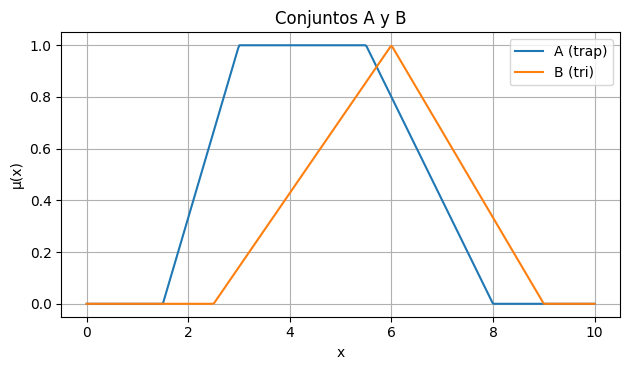

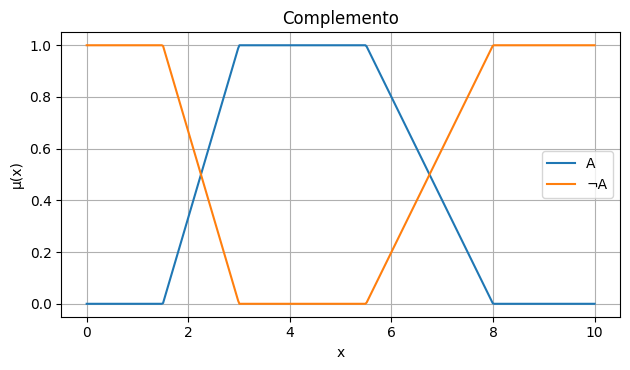

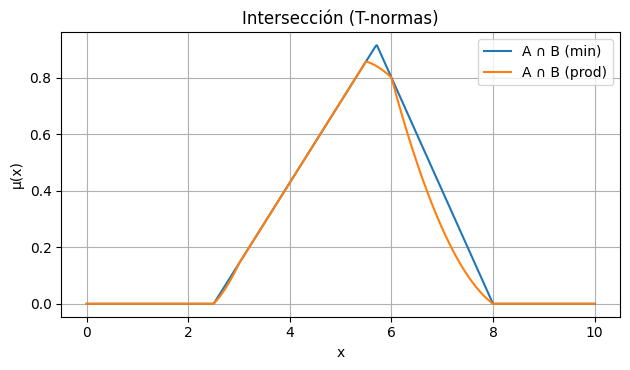

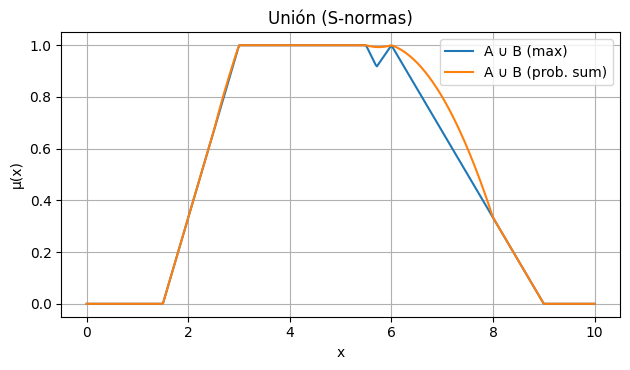

In [4]:
# 4) Operaciones sobre dos conjuntos (ejemplo A=trap, B=tri)
def fuzzy_ops_demo():
    A = trap(U, 1.5, 3.0, 5.5, 8.0)
    B = tri(U, 2.5, 6.0, 9.0)

    comp_A = 1 - A
    inter_min = np.minimum(A, B)
    inter_prod = A * B
    union_max = np.maximum(A, B)
    union_ps  = A + B - A*B  # suma probabilística

    # Figura 1: A y B
    plt.figure()
    plt.plot(U, A, label="A (trap)")
    plt.plot(U, B, label="B (tri)")
    plt.title("Conjuntos A y B")
    plt.xlabel("x"); plt.ylabel("μ(x)"); plt.legend(); show()

    # Figura 2: complemento de A
    plt.figure()
    plt.plot(U, A, label="A")
    plt.plot(U, comp_A, label="¬A")
    plt.title("Complemento")
    plt.xlabel("x"); plt.ylabel("μ(x)"); plt.legend(); show()

    # Figura 3: intersecciones
    plt.figure()
    plt.plot(U, inter_min, label="A ∩ B (min)")
    plt.plot(U, inter_prod, label="A ∩ B (prod)")
    plt.title("Intersección (T-normas)")
    plt.xlabel("x"); plt.ylabel("μ(x)"); plt.legend(); show()

    # Figura 4: uniones
    plt.figure()
    plt.plot(U, union_max, label="A ∪ B (max)")
    plt.plot(U, union_ps,  label="A ∪ B (prob. sum)")
    plt.title("Unión (S-normas)")
    plt.xlabel("x"); plt.ylabel("μ(x)"); plt.legend(); show()

fuzzy_ops_demo()

#### **Interpretación de las operaciones entre conjuntos borrosos**

Estas cuatro gráficas ilustran las **operaciones fundamentales de la teoría de conjuntos borrosos**, aplicadas a dos conjuntos difusos:

1. **Conjuntos A y B**
- En la primera gráfica se visualizan:
  - **A** (azul): función trapezoidal que representa una categoría con un rango central de pertenencia total (núcleo entre 3 y 5.5) y transiciones suaves en los extremos.
  - **B** (naranja): función triangular centrada en 6.0, con soporte entre 2.5 y 9.0.

> La **superposición parcial** entre ambos refleja la existencia de una zona de ambigüedad donde un elemento puede pertenecer simultáneamente a ambos conjuntos con diferentes grados — concepto clave en la lógica borrosa.

2. **Complemento**
- La segunda figura muestra el **complemento de A**, calculado como $\mu_{\bar A}(x) = 1 - \mu_A(x)$.
  - Representa los valores *no pertenecientes* a A.
  - A diferencia del complemento clásico, el cambio entre pertenencia y no pertenencia es **gradual**, no abrupto.
  - La suma $\mu_A(x) + \mu_{\bar A}(x)$ no es siempre igual a 1, lo que permite capturar incertidumbre.


3. **Intersección — T-normas**
- La tercera gráfica compara dos formas de intersección:
  - **Mínimo:** $\mu_{A \cap B}(x) = \min(\mu_A(x), \mu_B(x))$  
    → versión conservadora, toma el grado más bajo entre A y B.
  - **Producto:** $\mu_{A \cap B}(x) = \mu_A(x)\cdot\mu_B(x)$  
    → versión suavizada, penaliza la intersección más gradualmente.

> Ambas definen una **T-norma**, es decir, un operador que modela la conjunción lógica (“y”) de forma continua.  
Se observa cómo la intersección ocupa solo la región donde ambos conjuntos tienen valores significativos de pertenencia.


4. **Unión — S-normas**
- La cuarta figura representa la **unión borrosa** con dos formulaciones:
  - **Máximo:** $\mu_{A \cup B}(x) = \max(\mu_A(x), \mu_B(x))$
  - **Suma probabilística:** $\mu_{A \cup B}(x) = \mu_A + \mu_B - \mu_A \mu_B$

> Ambas son **S-normas**, operadores que generalizan el “o” lógico.  
La suma probabilística suaviza la transición y evita discontinuidades, proporcionando un modelo más realista de combinación.

**Interpretación conceptual**
- Estas operaciones demuestran que en la lógica borrosa no existen límites nítidos entre verdadero y falso.
- Cada punto $x$ tiene un **grado de pertenencia** que participa en operaciones continuas, preservando la información parcial.
- Estas bases permiten construir sistemas de inferencia borrosa, donde reglas del tipo *“si A y B entonces C”* se calculan mediante **T-normas y S-normas**.

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Variable lingüística y fuzzificación</font>

Definimos la **variable lingüística** “Temperatura” sobre $U=[0,40]$ con etiquetas:
- **Baja**: trapezoidal $(a,b,c,d)=(0,0,10,18)$  
- **Media**: triangular $(10,20,30)$  
- **Alta**: trapezoidal $(22,30,40,40)$

> Dado un valor nítido $x^*$, calculamos los grados $\mu_{\text{Baja}}(x^*)$, $\mu_{\text{Media}}(x^*)$, $\mu_{\text{Alta}}(x^*)$ y los representamos (barra o texto).

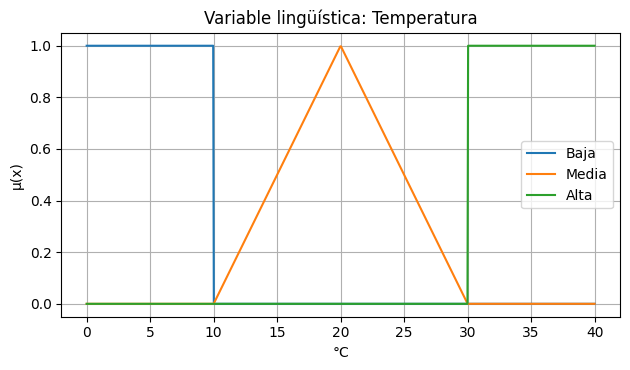

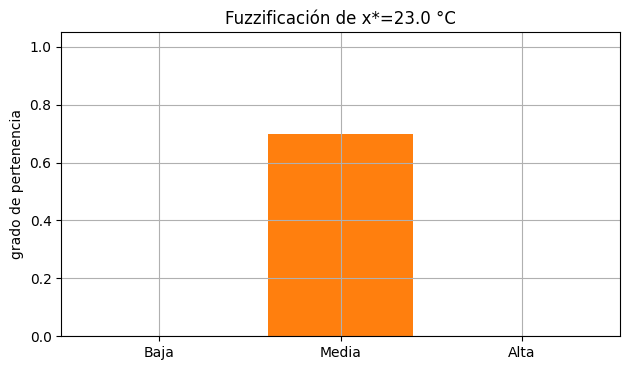

In [5]:
# 5) Variable lingüística: temperatura
U_T = sample_universe(0, 40, 800)

def temp_labels():
    baja  = trap(U_T, 0, 0, 10, 18)
    media = tri(U_T, 10, 20, 30)
    alta  = trap(U_T, 22, 30, 40, 40)
    return baja, media, alta

def plot_temp_labels():
    baja, media, alta = temp_labels()
    plt.figure()
    plt.plot(U_T, baja,  label="Baja")
    plt.plot(U_T, media, label="Media")
    plt.plot(U_T, alta,  label="Alta")
    plt.title("Variable lingüística: Temperatura")
    plt.xlabel("°C"); plt.ylabel("μ(x)"); plt.legend(); show()

def fuzzify_temp(x_star):
    baja, media, alta = temp_labels()
    # localizar índice más cercano en U_T
    idx = int(np.clip(np.searchsorted(U_T, x_star), 0, len(U_T)-1))
    μ = {
        "Baja":  float(baja[idx]),
        "Media": float(media[idx]),
        "Alta":  float(alta[idx]),
    }
    # gráfico de barras
    plt.figure()
    plt.bar(μ.keys(), μ.values(), color=["tab:blue","tab:orange","tab:red"])
    plt.ylim(0,1.05)
    plt.title(f"Fuzzificación de x*={x_star:.1f} °C")
    plt.ylabel("grado de pertenencia")
    show()
    return μ

plot_temp_labels()
_ = fuzzify_temp(23.0)

#### **Interpretación: Variable lingüística y fuzzificación**

Las gráficas muestran el proceso de **fuzzificación**, es decir, la conversión de un valor numérico concreto (crisp) en **grados de pertenencia** a distintos conjuntos borrosos que representan categorías lingüísticas.

1. **Variable lingüística: *Temperatura***
- La primera figura define la variable lingüística **“Temperatura”**, compuesta por tres términos:
    - **Baja**: modelada con una función trapezoidal activa entre 0 °C y 18 °C.
    - **Media**: modelada con una función triangular centrada en 20 °C.
    - **Alta**: modelada con una función trapezoidal que comienza a activarse a partir de 22 °C.

> Cada término lingüístico se asocia con una **función de pertenencia** $\mu(x)$ que cuantifica cuánto pertenece una temperatura al concepto correspondiente.  
Por ejemplo, una temperatura de 15 °C tiene $\mu_{\text{Baja}}(15) \approx 0.5$ y $\mu_{\text{Media}}(15) \approx 0.25$, lo que refleja una **zona de transición gradual** entre ambas categorías.


2. **Fuzzificación de una observación**

- La segunda gráfica muestra la **fuzzificación del valor** $x^* = 23.0\,°C$.  
- El sistema evalúa el grado de pertenencia de ese valor a cada conjunto:

<center>

| Término | Grado de pertenencia |
|----------|----------------------|
| Baja     | 0.0 |
| Media    | ≈ 0.7 |
| Alta     | 0.0 |

</center>

> El resultado indica que **23 °C se interpreta como una temperatura “Media” con un grado de 0.7**, es decir, pertenece moderadamente al conjunto “Media” y no pertenece a “Baja” ni a “Alta”.


3. **Significado conceptual**

- En la lógica borrosa, **un mismo valor puede pertenecer parcialmente a varios conjuntos**.  
  - Esto permite representar fenómenos continuos (como la temperatura o la velocidad) con términos lingüísticos discretos sin perder información.
- La fuzzificación constituye la **primera etapa** en un sistema de inferencia borroso:
  1. **Fuzzificación:** transforma la entrada numérica en valores difusos.
  2. **Inferencia:** aplica reglas del tipo “Si temperatura es Media entonces ventilador es Medio”.
  3. **Defuzzificación:** convierte el resultado difuso en una acción o valor numérico.


4. **Reflexión didáctica**
- Esta representación es clave para comprender la **semántica de los términos lingüísticos**:
    - Las fronteras entre categorías no son rígidas, sino **graduales y superpuestas**.
    - La **fuzzificación** es lo que permite a los sistemas borrosos manejar incertidumbre y ambigüedad, asemejando el razonamiento humano.

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Interacción: mueve x* y observa la fuzzificación</font>

Desplaza el punto $x^*$ para ver cómo se reparte la pertenencia entre etiquetas. Esto conecta con el **razonamiento borroso**: las reglas usarán estos grados como activación.

- Esta celda permite **explorar de forma interactiva el proceso de fuzzificación** de la variable lingüística *Temperatura*.  
- El control deslizante (`FloatSlider`) situado sobre la gráfica representa el valor de temperatura $x^*$ (en °C).  
- Al moverlo, el sistema calcula automáticamente el **grado de pertenencia** de ese valor a cada conjunto borroso:

    - **Baja** → μ_Baja(x*)  
    - **Media** → μ_Media(x*)  
    - **Alta** → μ_Alta(x*)

- El gráfico de barras muestra los resultados de manera visual:  
    - El eje *x* corresponde a los términos lingüísticos (“Baja”, “Media”, “Alta”).  
    - El eje *y* muestra el **grado de pertenencia** entre 0 y 1.

Por ejemplo, en la salida mostrada:
- Para $x^* = 21.0\,°C$, se obtiene una pertenencia **alta a “Media” (μ≈0.9)** y nula a las otras dos categorías.
- Esto significa que el sistema interpreta esa temperatura como *claramente media*, pero aún sin ser “alta”.


**Finalidad**
- Este ejercicio ilustra cómo los sistemas borrosos **transforman una entrada numérica precisa en una representación semántica difusa**.  
- La fuzzificación es el primer paso en cualquier sistema de inferencia borroso, permitiendo que las reglas del tipo:

> “Si la temperatura es *Media*, entonces el ventilador es *Moderado*”

In [7]:
# 6) Interactivo para fuzzificación (si hay ipywidgets)
if _HAS_WIDGETS:
    interact(
        fuzzify_temp,
        x_star=FloatSlider(
            value=20,     # valor inicial
            min=0,        # mínimo
            max=40,       # máximo
            step=0.5,     # incremento
            description="Temperatura (°C)"
        )
    )
else:
    # Fallback: muestra tres ejemplos fijos si no hay widgets disponibles
    for xs in (8, 20, 33):
        fuzzify_temp(xs)

interactive(children=(FloatSlider(value=20.0, description='Temperatura (°C)', max=40.0, step=0.5), Output()), …

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Conclusiones</font>

- Las funciones de pertenencia **modelan etiquetas** de lenguaje natural; sus parámetros **ajustan la semántica**.
- Las operaciones borrosas permiten **combinar etiquetas** (conjunciones/disyunciones) de forma suave.
- La **fuzzificación** convierte valores nítidos en **grados** que se usarán en las reglas (próximo cuaderno).